# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо постройть модель с предельно большим значением *F1*-меры. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Загрузка библиотек.

In [16]:
#загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Открытие файла.

In [17]:
#сохранение датафрейма в переменную
try:
    df = pd.read_csv("/datasets/Churn.csv", index_col = 0)
except:
    df = pd.read_csv("Churn.csv",index_col = 0)

df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Вывод информации о таблице.

In [18]:
#информация о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


**Первичные выводы**

В данном датафрейме имеются ряд неточностей и пропусков что повлияют на корректную работу с данными и построение моделей.
К к таким недостатком можно отнести:
* Неправильный регистр названия столбцов.
* Пропуски в столбце.  

Также в датафрейме имеются 2 столбца с неинформативными данными для обучения модели customer_id и surname. Данные столбцы исключим из датафрейма.


Сперва изменим регистра на змеиный.  
Для простоты исравления добавим функцию и применим ее на названия столбцов.

In [19]:
#функция изменения регистра
def camel_to_snake(str, sep='_'):
    snake_register = ''
    for i in str:
        if i.isupper():
            snake_register += sep + i.lower()
        else:
            snake_register += i
    return snake_register.lstrip(sep)

In [20]:
#применение функции на названия столбцов
df.columns  = [camel_to_snake(x) for x in df]

Проверим изменения.

In [21]:
#вывод названия столбцов
df.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Обработаем пропуски в столбце Tenure.  
Выведем уникальные значения для лучшего понимания данных которые необходимо обработать.

In [22]:
#вывод уникальных значений
df.tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Посмотрим количество каждых значений.

In [23]:
#вывод количества каждого значения
df.tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

Содержашиеся значения имеют разброс от 1 до 10, также значения типа int.  
Т.к данных недостаточно для корректного заполнения пропусков. Просто заполним пропуски нулями и предположим что клиенты нулевого года.  


In [24]:
#заполнение пропусков 
df["tenure"] = df["tenure"].fillna(0)

Проверим изменения.

In [25]:
#вывод количества каждого значения
df.tenure.value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: tenure, dtype: int64

Пропуски заполнены   
Приведём данный столбец к типу int.

In [26]:
#смена типа данных
df.tenure = df.tenure.astype(int)

Осталось удалить неинформативные столбцы.

In [27]:
#удаление столбцов
df = df.drop(["surname","customer_id"],axis = 1)



Проверим признаки на мультиколлинеарность.  
Выставим пороговое значение корреляции 0.7.

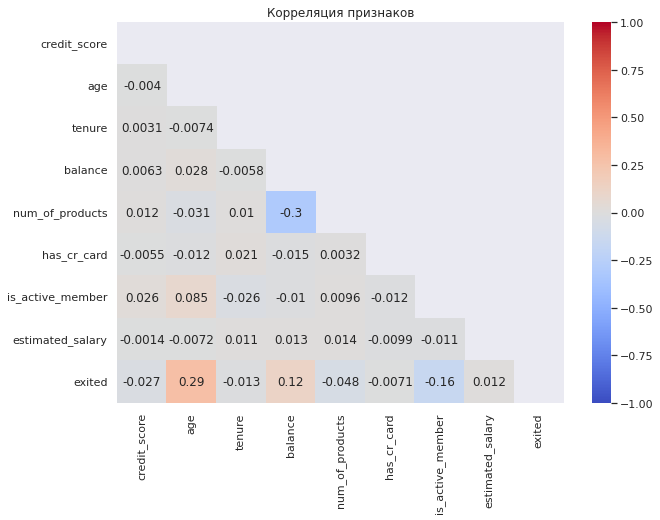

In [28]:
#выделим значения для сокрытия их в тепловой карте
upp_mat = np.triu(df.corr())
#построение тепловой карты корреляции признаков
sns.set(rc = {'figure.figsize':(10,7)})
sns.heatmap(df.corr(),vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
plt.title("Корреляция признаков")
plt.show()

Мультиколлинеарность отсутствует. 

Для правильного обучения модели применим для cтолбцов прямое кодирование. Сохраним в новую перемунную.

In [29]:
#кодирование признаков
df_ohe = pd.get_dummies(df, columns = ["gender", "geography"], drop_first = True)

Выделим из датафрейма признаки и целевой признак.

In [30]:
#выделение признаков
features = df_ohe.drop("exited",axis =1)
target = df_ohe["exited"]

Разделение признаков на обучающие,валидационные и тестовые.

In [31]:
#разделение признаков
features_train,features_test,target_train,target_test = train_test_split(features,
                                                                         target,
                                                                         test_size = 0.4,
                                                                         random_state = 12345)
features_test,features_valid,target_test,target_valid = train_test_split(features_test,
                                                                         target_test,
                                                                         test_size = 0.5,
                                                                         random_state = 12345)

Проверим соотношение данных в каждой ваборке.

In [32]:
#вывод количества объектов в каждой выборке
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


Данные распределены хорошо.

Отмасштабируем признаки для того чтобы модель не выделяла признаки с высокими значениями как наиболее выжные.

In [33]:
#выделение признаков для масштабирования
numeric = ["credit_score", "balance","estimated_salary","age"]
#создание объекта структуры данных
scaler = StandardScaler()
scaler.fit(features_train[numeric])
#трансформация признаков
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Вывод**

Для дальнейшей работы по построению модели были обработаны и изменины ряд данных.
* Был изменён регистр столбцов и заполнены пропуски в столбце Tenure.
* Был произведен поиск зависимостей признаков чтобы избежать мультиколлинеарности что влияет на обучение модели.
* Было применено порядковое кодирование на некоторые признаки типа object.
* Произведено разделение на обучающую,валидационную, тестовую выборки.
* произведено масштабирование признаков.

Данные подготовлены для дальнейшего обучения модели.

## Исследование задачи

Выберем 3 модели для построения прогнозов.
* DecisionTreeClassifier
* RandomForestClassifie
* LogisticRegressor  
Обучим эти модели на тренировочных данных без учета баланса классов. Для проверки одновременно и точности и полноты используем f1-меру.

Так же для каждой модели будем считать AUC_ROC.

Для дальнейшей работы напишем несколько функций поиска оптимальных моделей. Добавим возможность балансировки классов.

In [34]:
#Функция для случайного леса
def random_forest(features_train, target_train, features_test, target_test, balance = None):
    best_forest_depht = 0
    best_nest = 0
    best_f1 = 0
    auc_roc = 0
    best_model = RandomForestClassifier()

    for est in range(10, 101, 10):
        for depth in range(1,20):
            model = RandomForestClassifier(random_state = 12345,
                                       n_estimators = est, 
                                       max_depth = depth)
            model.fit(features_train, target_train)
            predictions = model.predict(features_test)
            f1 = f1_score(target_test,predictions)
            if f1>best_f1:
                best_f1 =f1
                best_forest_depth = depth
                best_nest = est
                best_model = model
            
    probabilities_test = best_model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(target_test,probabilities_one_test)

    print("Лучшая модель Случайного леса")
    print("f1-мера:",best_f1)
    print("Глубина деревьев:",best_forest_depth)
    print("Количество деревьев:",best_nest)
    print("AUC_ROC:",auc_roc)

In [35]:
#Функция для дерева решений
def decision_tree(features_train, target_train, features_test, target_test, balance = None):
    best_tree_depht = 0
    best_f1 = 0
    auc_roc = 0
    best_model = DecisionTreeClassifier()

    for depth in range(1,20):
        model = DecisionTreeClassifier(random_state = 12345,
                                       max_depth = depth,
                                       class_weight = balance)
        model.fit(features_train, target_train)
        predictions = model.predict(features_test)
        f1 = f1_score(target_test, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_tree_depth = depth
            best_model = model
            
    probabilities_test = best_model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(target_test,probabilities_one_test)
    
    print("Лучшая модель Дерева решений")
    print("f1-мера:",best_f1)
    print("Глубина дерева:",best_tree_depth)
    print("AUC_ROC:",auc_roc)

Приступим к поиску лучшей модели для прогноза.

In [36]:
#построение модели
decision_tree(features_train,target_train,features_valid,target_valid)

Лучшая модель Дерева решений
f1-мера: 0.5337423312883436
Глубина дерева: 6
AUC_ROC: 0.8394526219847661


In [37]:
#построение модели
random_forest(features_train,target_train,features_valid,target_valid)

Лучшая модель Случайного леса
f1-мера: 0.5621301775147929
Глубина деревьев: 18
Количество деревьев: 80
AUC_ROC: 0.8520052588105314


In [38]:
#Логистическая регрессия

auc_roc = 0

#подсчет точноси для логистической регрессии
model = LogisticRegression(random_state = 12345, solver='liblinear')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1 = f1_score(target_valid,predictions)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
        
print("f1-мера:",f1)
print("AUC_ROC:",auc_roc)

f1-мера: 0.2743055555555555
AUC_ROC: 0.7387804296694054


**Выводы**

Построив 3 разные модели мы видим что наибольшую f1-меру показала модель случайного леса. Т.к модель случайного леса создает независмые деревья а потом усредняет ответы то выделим эту модель как наиболее подходящую для прогнозирования.  
AUC_ROC для этой модели также высок, это означает что чем выше этот показатель тем истинней и постоянней способность модели к прогнозированию.  
В дальнейшем будем использовать эту модель.

## Борьба с дисбалансом

Модель рандомного леса была выделена как наиболее подходящая для построения прогнозов. Но т.к. данные возможно имеют дисбаланс классов то это тоже влияет на точность модели и приводит к тому что определённый класс становится более значимым.  
Также применим модель дерева решиений для сравнения моделей при балансе классов.

Чтобы этого избежать применим 3 метода для балансировки классов и посмотрим какой из них даёт больщую точность.

Проверим какой класс является редким и покажем это на столбчатой диаграмме.

In [39]:
#вывод количества значений каждого класса
target_train.value_counts(normalize= True)

0    0.800667
1    0.199333
Name: exited, dtype: float64

In [40]:
#построение диаграммы
fig = px.bar(target_train.value_counts(),
             title = "Соотношение классов")
fig.show()

Видно что класс "1" является редким.

Напишем функцию upsampled которая увеличивает количество объектов редкого класса.  
Сразу можно сказать что из за увеличения выборки модель обучается лучше и даёт прогноз точнее.

Запишим выборки в новые переменные.

In [ ]:
#функция увеличивающая количество редкого класса

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#создание новых переменных
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

Применим новые обучающие выборки для обучения моделей.

In [ ]:
#построение модели
random_forest(features_upsampled,target_upsampled,features_valid,target_valid)

Лучшая модель Случайного леса
f1-мера: 0.6205191594561187
Глубина деревьев: 12
Количество деревьев: 10
AUC_ROC: 0.8443996216294817


In [ ]:
#построение модели
decision_tree(features_upsampled,target_upsampled,features_valid,target_valid)

Лучшая модель Дерева решений
f1-мера: 0.5851780558229066
Глубина дерева: 7
AUC_ROC: 0.813748461558065


Напишем функцию downsample для понижения количества преобладающего класса.

In [ ]:
#функция уменьшения объектов преообладающего класса

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

#создание новых переменных
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

Применим новые обучающие выборки для обучения моделей.

In [ ]:
#построение модели
random_forest(features_downsampled,target_downsampled,features_valid,target_valid)

Лучшая модель Случайного леса
f1-мера: 0.6058091286307055
Глубина деревьев: 8
Количество деревьев: 10
AUC_ROC: 0.8456318742682563


In [ ]:
#построение модели
decision_tree(features_downsampled,target_downsampled,features_valid,target_valid)

Лучшая модель Дерева решений
f1-мера: 0.5905905905905907
Глубина дерева: 5
AUC_ROC: 0.8287671027521808


Измерим точность с балансировкой классов через передачу агрумента class_weight.

In [ ]:
#построение модели
random_forest(features_train,target_train,features_valid,target_valid,balance = "balanced")

Лучшая модель Случайного леса
f1-мера: 0.5621301775147929
Глубина деревьев: 18
Количество деревьев: 80
AUC_ROC: 0.8520052588105314


In [ ]:
#построение модели
decision_tree(features_train,target_train,features_valid,target_valid,balance = "balanced")

Лучшая модель Дерева решений
f1-мера: 0.5809128630705395
Глубина дерева: 5
AUC_ROC: 0.8355347481752318


**Вывод**

Рассмотрев модели с балансировкой классов по 3 разным методам можно прийти к заключению, что метод в котором увеличивается выборка путем повышения объекта редкого класса наиболее эффективен.  Он увеличил показатель f1-меры до 62%. AUC_ROC осталась почти на томже уровне что говорит что при применении модели на тестовой выборке f1-мера не должна сильно меняться. Модель случайного леса опять же показал лучший результат в отличии от дерева решений.

## Тестирование модели

Из проведённых исследований складывается вывод о том что модель RandomForestClassifier с гиперпараметрами max_depth = 12 и n_estimators = 10 наиболее подходящая модель для данной задачи. Но перед этим объединим тестовую и валидационную выборки и применим метод увеличения объектов редкого класса для нахождения лучшего результата.  

Проверим данную модель и на тестовых данных и узнаем показатели f1-меры и AUC_ROC. 

In [ ]:
#объединение выборок
features_train_valid = pd.concat([features_train] + [features_valid])
target_train_valid = pd.concat([target_train] + [target_valid])

#перемешивание выборки
features_train_valid, target_train_valid = shuffle(features_train_valid, 
                                                   target_train_valid, 
                                                   random_state=12345)

In [ ]:
#увеличение выборки
features_tv_upsampled, target_tv_upsampled = upsample(features_train_valid, 
                                                      target_train_valid,
                                                      2)

In [ ]:
#обучение модели случайного леса с оптимальными гиперпараметрами и балансом классов
model = RandomForestClassifier(random_state = 12345,
                               n_estimators = 10, 
                               max_depth =12)
model.fit(features_tv_upsampled, target_tv_upsampled)
predictions = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test,probabilities_one_test)
print("f1-мера:",f1_score(target_test,predictions))
print("AUC_ROC:",auc_roc)

f1-мера: 0.6187419768934531
AUC_ROC: 0.8433876323955504


Видим что модель справилась с поставленной задачей в пороговом значении f1-меры - 0.59.